In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chisquare
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
# sharper plots
%config InlineBackend.figure_format = 'retina'

import plotly.express as px
import os, re

Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (те, кто разместил эти объявления).

ads_data.csv – данные взаимодействий с рекламными объявлениями
date – дата
time – время
event – действие (просмотр/клик)
platform – платформа
ad_id – id объявления
client_union_id – id рекламного кабинета
campaign_union_id – id рекламной кампании
ad_cost_type – тип оплаты
ad_cost – цена
has_video – есть ли видео
target_audience_count – размер аудитории

ads_clients_data.csv – характеристики рекламных клиентов
date – дата
client_union_id – id рекламного кабинета
community_id – id сообщества
create_date – дата создания рекламного клиента

In [4]:
ads_data    = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\6\\Задания\\Минипроект\\ads\\ads_data.csv")
ads_clients = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\6\\Задания\\Минипроект\\ads\\ads_clients_data.csv")

In [5]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [6]:
ads_clients.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


#### Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

In [47]:
ads_per_id_and_event = ads_data.groupby(['ad_id','event'], as_index=False)\
                            .agg({"time":"count"})

In [48]:
pivot_ads_event = ads_per_id_and_event.pivot(columns='event', index='ad_id', values='time').fillna(0)

In [49]:
pivot_ads_event.mean().round()

event
click    113.0
view     923.0
dtype: float64

#### Нарисуйте график распределения показов на объявление за весь период.

In [105]:
views_on_ads = ads_per_id_and_event.query('event == "view"')
views_on_ads

,ad_id,event,time
1,2,view,101
3,3,view,184
5,1902,view,41
6,2064,view,35
8,2132,view,58
...,...,...,...
1475,122004,view,100
1476,122013,view,156
1477,122023,view,68
1479,122031,view,138


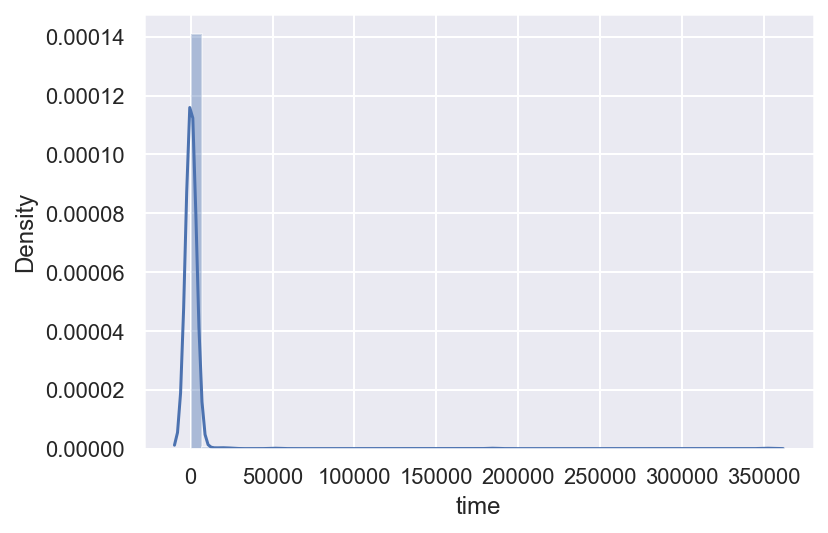

In [70]:
sns.distplot(views_on_ads.time);

In [71]:
views_on_ads.time.describe()

count       956.000000
mean        931.822176
std       13006.492754
min          10.000000
25%          36.000000
50%          84.000000
75%         209.250000
max      351802.000000
Name: time, dtype: float64

Тк тут слишком много редко встречающихся больших значений, можно взять логарифм от данных

In [81]:
sns.set(font_scale=2, style='whitegrid', rc={'figure.figsize':(8,6)})

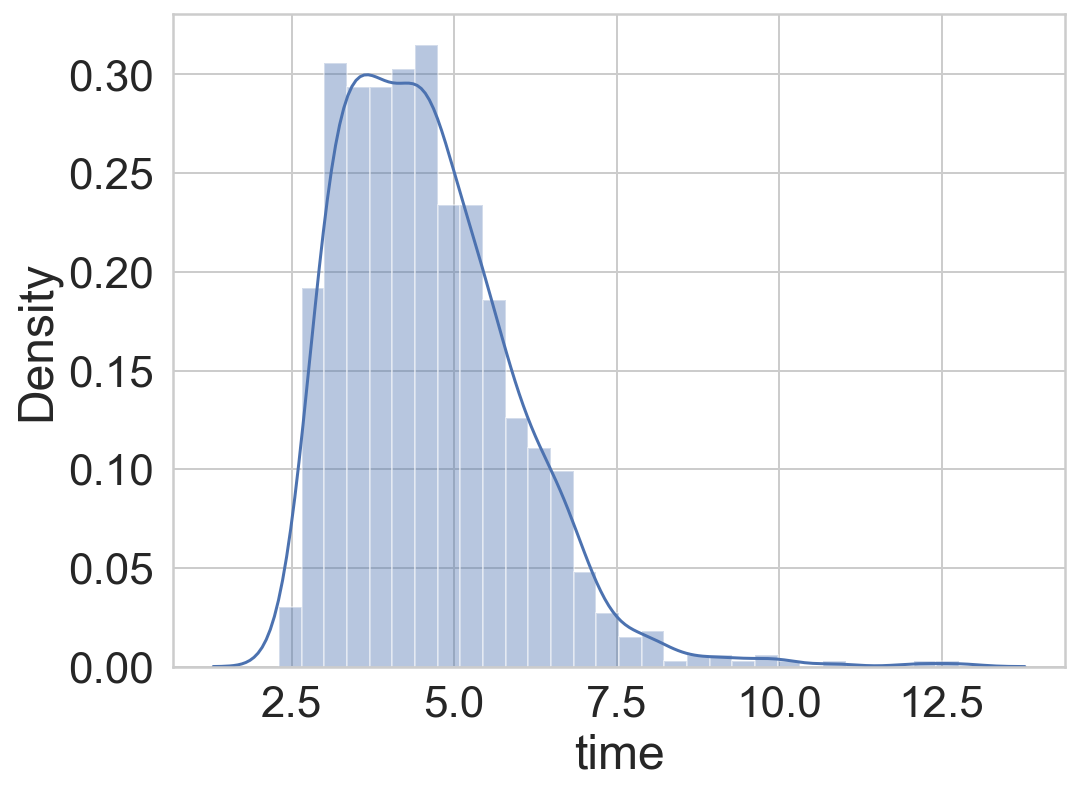

In [82]:
sns.distplot(np.log(views_on_ads.time));

In [74]:
np.log(views_on_ads.time).describe()

count    956.000000
mean       4.597903
std        1.330069
min        2.302585
25%        3.583519
50%        4.430817
75%        5.343528
max       12.770824
Name: time, dtype: float64

#### А теперь давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?

In [166]:
ads_data.query('event == "view"').groupby(['ad_id','date'], as_index=False).agg({'time':'count'})\
        .pivot(columns='date', index='ad_id').mean().rolling(2).mean()

      date      
time  2019-04-01           NaN
      2019-04-02    146.134626
      2019-04-03    150.869880
      2019-04-04    419.927249
      2019-04-05    797.505699
      2019-04-06    598.116202
dtype: float64

In [315]:
pivot_ad_id_date = ads_data.query('event == "view"').pivot_table(columns='date', index='ad_id', values='time', aggfunc='count')
pivot_ad_id_date.mean().rolling(2).mean()

date
2019-04-01           NaN
2019-04-02    146.134626
2019-04-03    150.869880
2019-04-04    419.927249
2019-04-05    797.505699
2019-04-06    598.116202
dtype: float64

#### Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем.

'2019-04-06'

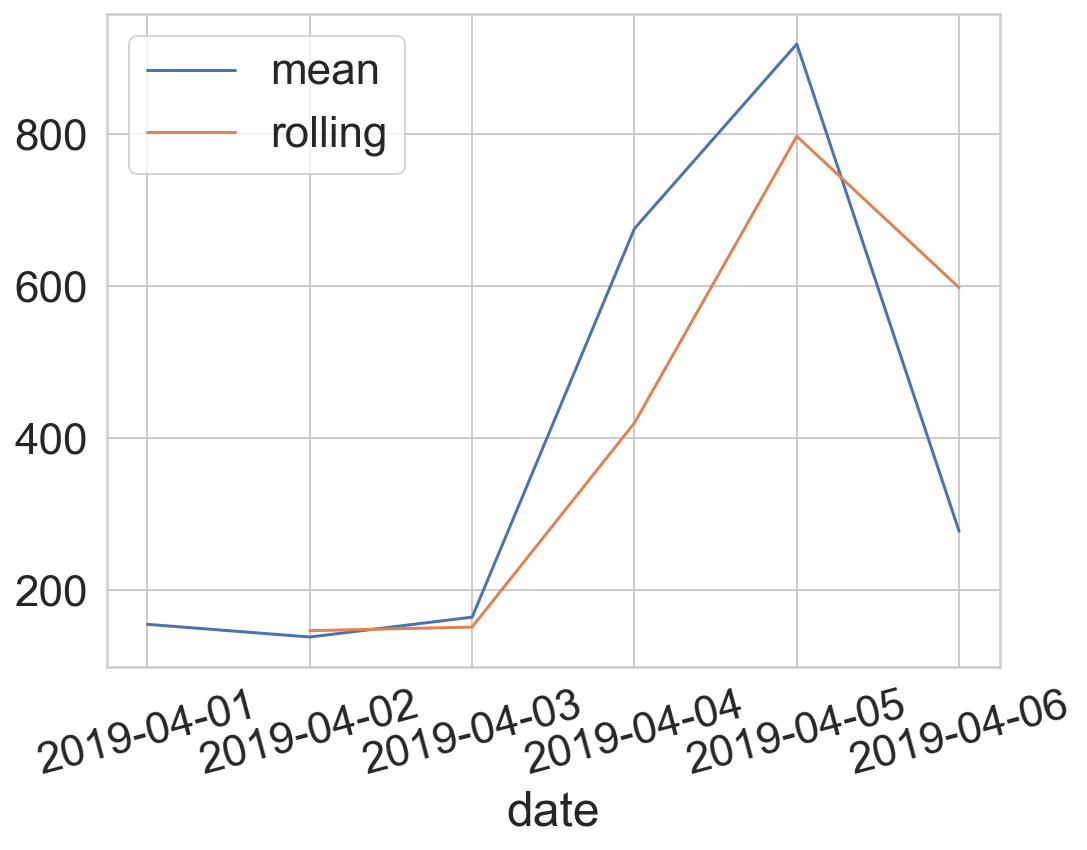

In [240]:
rolling_mean = pivot_ad_id_date.mean().rolling(2).mean()
mean = pivot_ad_id_date.mean()
ax = sns.lineplot(x=mean.index, y=mean.values, data=mean, label='mean');
ax = sns.lineplot(x=rolling_mean.index, y=rolling_mean.values, data=rolling_mean, label='rolling');

for item in ax.get_xticklabels():
    item.set_rotation(15)
    
abs(rolling_mean - mean).idxmax()

#### *Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименишим количеством показов) в день, в который была замечена самая большая по модулю аномалия.

In [278]:
def find_anomaly(df: pd.DataFrame):
    '''
    Поиск объявления с минимальным/максимальным количеством показов 
    в день с наибольшей по модулю аномалией 
    
    Параметры
    ---------
    df: pd.DataFrame
        Датасет
        
    '''
    
    pivot_ad_id_date = df.query('event == "view"').pivot_table(columns='date', index='ad_id', values='time', aggfunc='count')
    mean = pivot_ad_id_date.mean()
    rolling_mean = mean.rolling(2).mean()
    mean_diff = rolling_mean - mean
    date_max_anom = mean_diff.abs().idxmax()
    
    max_ = mean_diff[date_max_anom] > 0
    
    if max_ == True:
        return pivot_ad_id_date[str(date_max_anom)].idxmax()
    elif max_ == False:
        return pivot_ad_id_date[str(date_max_anom)].idxmin()
    else:
        return


In [279]:
find_anomaly(ads_data)

112583

#### *Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

In [295]:
# Необходимо для уменьшения затрат на мерж
our_clients = ads_data.client_union_id.unique()#groupby('client_union_id', as_index=False).agg({'time':'count'})

In [301]:
ads_clients = ads_clients[ads_clients.client_union_id.isin(our_clients)]

In [322]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [326]:
first_ad_for_union = ads_data.merge(ads_clients, on='client_union_id')\
                        .groupby('client_union_id', as_index=False).agg({'date_x':np.min})\
                        .rename(columns={'date_x':'first_start'})
first_ad_for_union.head()

,client_union_id,first_start
0,1,2019-04-01
1,9,2019-04-03
2,13,2019-04-02
3,16,2019-04-03
4,20,2019-04-02


In [332]:
union_create_start = ads_clients.\
                        merge(first_ad_for_union, on='client_union_id')[["client_union_id", "create_date", "first_start"]]
union_create_start

,client_union_id,create_date,first_start
0,1,2018-12-24,2019-04-01
1,9,2018-12-10,2019-04-03
2,13,2019-01-26,2019-04-02
3,16,2018-12-19,2019-04-03
4,20,2019-03-01,2019-04-02
...,...,...,...
833,122004,2019-01-24,2019-04-01
834,122013,2018-11-04,2019-04-04
835,122023,2018-11-29,2019-04-04
836,122031,2018-12-30,2019-04-05


In [341]:
union_create_start['create_date'] = pd.to_datetime(union_create_start['create_date'])
time_before_start = union_create_start.first_start - union_create_start.create_date 
time_before_start.mean()

Timedelta('124 days 09:04:43.532219570')

#### *Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))

In [358]:
converted_clients = time_before_start.loc[time_before_start < pd.Timedelta(365, unit='d')]
converted_clients

0      98 days
1     114 days
2      66 days
3     105 days
4      32 days
        ...   
833    67 days
834   151 days
835   126 days
836    96 days
837    71 days
Length: 838, dtype: timedelta64[ns]

In [366]:
ads_all_clients = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\6\\Задания\\Минипроект\\ads\\ads_clients_data.csv")
conv_num = round((converted_clients.shape[0] / ads_all_clients.client_union_id.nunique()) * 100, 2)
print(f"Конверсия в запуск рекламной кампании составила {conv_num}%")

Конверсия в запуск рекламной кампании составила 0.69%


#### *Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]

In [369]:
union_create_start['delta'] = union_create_start.first_start - union_create_start.create_date
union_delta = union_create_start[['client_union_id', 'delta']]

In [412]:
bins_list = [0, 30, 90, 180, 365]
bins = [pd.to_timedelta(day, unit='d') for day in bins_list]
# bins = pd.to_timedelta([0, 30, 90, 180, 365, 999], unit='d')
bin_labels = [str(bin1)+'-'+str(bin2) for bin1, bin2 in zip(bins_list[:-1], bins_list[1:])]

In [413]:
union_delta['delta_cat'] = pd.cut(union_delta['delta'], bins=bins, labels=bin_labels)

In [414]:
union_delta.delta_cat.value_counts()

90-180     396
30-90      263
180-365    168
0-30        11
Name: delta_cat, dtype: int64

#### *А теперь давайте выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

In [415]:
cat_counts = union_delta.delta_cat.value_counts()
fig = px.bar(cat_counts, x=cat_counts.index, y=cat_counts.values, labels=dict(x="Cat", y="Amount"))
fig.show()